### Model Training and Validation

In [1]:
!pip install transformers torch matplotlib transformers[torch]


In [3]:
import torch
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments
import matplotlib.pyplot as plt

In [7]:
print(torch.cuda.current_device())

0


In [6]:
# !/export CUDA_VISIBLE_DEVICES=2
# torch.cuda.set_device(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2', pad_token_id=tokenizer.eos_token_id)
model.to(device)

# Prepare dataset
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path="/content/tiny_shakespare.txt",
    block_size=128)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False)

In [ ]:
pip install accelerate -U

In [11]:
# Setup training arguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=30,
    per_device_train_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    gradient_accumulation_steps=4,  # Increase if GPU memory is a limitation
  )

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

In [12]:
# Train and save the model
trainer.train()

Step,Training Loss
10,4.813700
20,4.813100
30,4.596200
40,4.446600
50,4.255200
60,4.225200
70,4.160200
80,4.130700
90,4.097400
100,3.993200


TrainOutput(global_step=4950, training_loss=2.664968262874719, metrics={'train_runtime': 1813.2186, 'train_samples_per_second': 43.679, 'train_steps_per_second': 2.73, 'total_flos': 5173582233600000.0, 'train_loss': 2.664968262874719, 'epoch': 30.0})

In [13]:
trainer.save_model('./fine_tuned_gpt2')

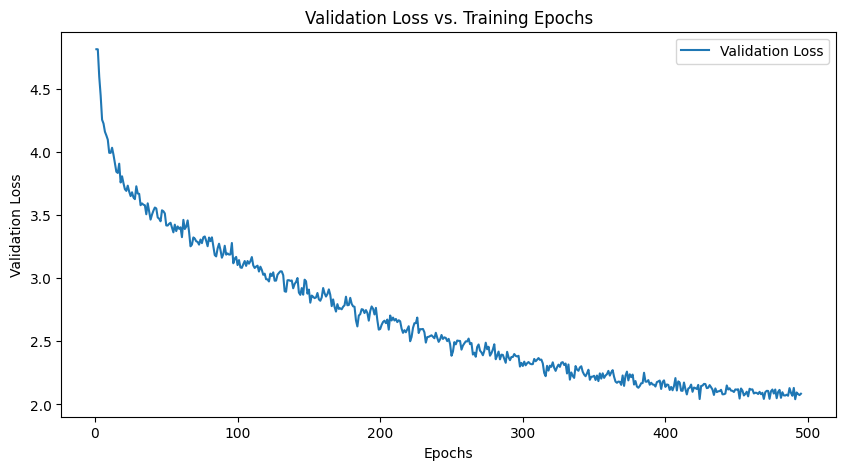

In [14]:
import matplotlib.pyplot as plt

# Assuming trainer.state.log_history contains the relevant data
loss_values = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
epochs = list(range(1, len(loss_values) + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, label='Validation Loss')
plt.title('Validation Loss vs. Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

### Text Generation

In [15]:
def generate_text(prompt, model, tokenizer):
    inputs = tokenizer.encode(prompt, return_tensors='pt').to(model.device)
    outputs = model.generate(inputs, max_length=100, num_return_sequences=1)
    text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"Prompt: {prompt}\nGenerated text: {text}\n")

# Load the original model and the fine-tuned model
original_model = GPT2LMHeadModel.from_pretrained('gpt2')
fine_tuned_model_10 = GPT2LMHeadModel.from_pretrained('./results/checkpoint-2500')
fine_tuned_model_30 = GPT2LMHeadModel.from_pretrained('./fine_tuned_gpt2')

# Generate text
prompts = ["To be or not to be", "A horse! a horse! my kingdom for a horse!"]
for prompt in prompts:
    print("Original Model:")
    generate_text(prompt, original_model, tokenizer)
    print("Fine-tuned Model after 10 epochs:")
    generate_text(prompt, fine_tuned_model_10, tokenizer)
    print("Fine-tuned Model after 30 epochs:")
    generate_text(prompt, fine_tuned_model_30, tokenizer)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Original Model:
Prompt: To be or not to be
Generated text: To be or not to be, the only thing that matters is that you're a good person.

I'm not saying that you should be a good person. I'm saying that you should be a good person.

I'm not saying that you should be a good person. I'm saying that you should be a good person.

I'm not saying that you should be a good person. I'm saying that you should be a good person.

I'm not

Fine-tuned Model after 10 epochs:
Prompt: To be or not to be
Generated text: To be or not to be,
I'll be a fool, and be a fool I am.

JULIET:
O, I am a fool!

Nurse:
You are a fool!

JULIET:
I am a fool!

Nurse:
You are a fool!

JULIET:
I am a fool!

Nurse:
You are a fool!

JULI

Fine-tuned Model after 30 epochs:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: To be or not to be
Generated text: To be or not to be;
For what is it, that we must call it so?

TYBALT:
It is a sacrament, sir, to be call'd
By some other name than your own:
And yet you speak strange: what is it?

TYBALT:
A sacrament, sir, to be call'd by some other name
Than my own name: and yet you speak strange:
What is it, that we must call

Original Model:
Prompt: A horse! a horse! my kingdom for a horse!
Generated text: A horse! a horse! my kingdom for a horse! a horse! my kingdom for a horse! a horse! my kingdom for a horse! a horse! my kingdom for a horse! a horse! my kingdom for a horse! a horse! my kingdom for a horse! a horse! my kingdom for a horse! a horse! my kingdom for a horse! a horse! my kingdom for a horse! a horse! my kingdom for a horse! a horse! my kingdom for a

Fine-tuned Model after 10 epochs:
Prompt: A horse! a horse! my kingdom for a horse!
Generated text: A horse! a horse! my kingdom for a horse!

KING RICHARD II:
What, ho! what, horse!

RATCLIFF:


### Hyperparameter Tuning and Model Optimization

In [19]:
# Define different hyperparameter configurations
configurations = [
    {'learning_rate': 5e-5, 'batch_size': 16},
    {'learning_rate': 3e-5, 'batch_size': 16},
]


model = GPT2LMHeadModel.from_pretrained('gpt2', pad_token_id=tokenizer.eos_token_id)
model.to(device)

training_args.learning_rate = configurations[0]['learning_rate']
training_args.per_device_train_batch_size = configurations[0]['batch_size']

trainer = Trainer(
     model=model,
     args=training_args,
     data_collator=data_collator,
     train_dataset=train_dataset,
)
trainer.train()
print(f"Hyperparameters: {configurations[0]}")

Step,Training Loss
10,4.840800
20,4.719600
30,4.601800
40,4.423100
50,4.316300
60,4.199800
70,4.100700
80,4.076700
90,3.993200
100,3.932300


Hyperparameters: {'learning_rate': 5e-05, 'batch_size': 16}


In [20]:
trainer.save_model('./fine_tuned_gpt2_1')
model_1 = GPT2LMHeadModel.from_pretrained('./fine_tuned_gpt2_1')

In [21]:
generate_text("To be or not to be", model_1, tokenizer)

Prompt: To be or not to be
Generated text: To be or not to be,
I'll be a slave to my master's will.

KING RICHARD III:
What, is't a slave to your will?

QUEEN ELIZABETH:
No, my lord; I'll be your master.

KING RICHARD III:
Then, by my will, I'll be your master.

QUEEN ELIZABETH:
Then, by my will, I'll



In [22]:
model = GPT2LMHeadModel.from_pretrained('gpt2', pad_token_id=tokenizer.eos_token_id)
model.to(device)

training_args.learning_rate = configurations[1]['learning_rate']
training_args.per_device_train_batch_size = configurations[1]['batch_size']

trainer = Trainer(
     model=model,
     args=training_args,
     data_collator=data_collator,
     train_dataset=train_dataset,
)
trainer.train()
print(f"Hyperparameters: {configurations[1]}")

Step,Training Loss
10,4.843100
20,4.754400
30,4.691800
40,4.529300
50,4.423300
60,4.309900
70,4.218400
80,4.189000
90,4.104900
100,4.042800


Step,Training Loss
10,4.843100
20,4.754400
30,4.691800
40,4.529300
50,4.423300
60,4.309900
70,4.218400
80,4.189000
90,4.104900
100,4.042800


Hyperparameters: {'learning_rate': 3e-05, 'batch_size': 16}


In [23]:
trainer.save_model('./fine_tuned_gpt2_2')
model_2 = GPT2LMHeadModel.from_pretrained('./fine_tuned_gpt2_2')

In [24]:
generate_text("To be or not to be", model_2, tokenizer)

Prompt: To be or not to be
Generated text: To be or not to be,
I'll be a slave to the law.

LEONTES:
I'll be a slave to the law,
And I'll be a slave to the law.

PAULINA:
I'll be a slave to the law,
And I'll be a slave to the law.

LEONTES:
I'll be a slave to the law,
And I'll be a slave to the law.



